### Build custum Vision Transformer model

In [15]:
import torch
import random
import timeit
import math
import numpy 
import numpy as np
from torch import optim
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
@dataclass
class vit_config:
    num_channels: int = 3
    batch_size:int = 16
    image_size: int = 224
    patch_size: int = 16
    num_heads:int = 8
    dropout: float = 0.0
    hidden_size: int = 768
    layer_norm_eps: float = 1e-6
    num_encoder_layers: int = 12
    random_seed: int = 42
    epochs: int = 30
    num_classes: int = -1              # will be replaced during data preprocess
    learning_rate: float = 1e-5
    adam_weight_decay: int = 0
    adam_betas: tuple = (0.9, 0.999)
    embd_dim: int = (patch_size ** 2) * num_channels           # 768
    num_patches: int = (image_size // patch_size) ** 2         # 196
    device: str = "cuda" if torch.cuda.is_available() else "cpu" 
    

In [17]:
config = vit_config

random.seed(config.random_seed)
numpy.random.seed(config.random_seed)
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

### Embedding

In [18]:
class VisionEmbedding(nn.Module):
    def __init__(self, config: vit_config):
        super().__init__()
        
        self.config  = config
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(
                in_channels=config.num_channels,
                out_channels=config.embd_dim,
                kernel_size=config.patch_size,
                stride=config.patch_size,
                padding="valid"
            ),
            nn.Flatten(start_dim=2)
        )
        
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, config.embd_dim)), requires_grad=True)
        self.pos_embeddings = nn.Parameter(torch.randn(size=(1, config.num_patches + 1, config.embd_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=config.dropout)
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        
        patch_embd = self.patch_embedding(x).transpose(2,1)
        patch_embd = torch.cat([cls_token, patch_embd], dim=1)
        embd = self.pos_embeddings + patch_embd
        embd = self.dropout(embd)
        return embd

### Attention

In [25]:
class VisionAttention(nn.Module):
    def __init__(self, config:vit_config):
        super().__init__()
        
        self.embd_dim = config.embd_dim
        self.num_heads = config.num_heads
        self.dropout = config.dropout
        
        self.q_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.k_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.v_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.out_proj = nn.Linear(self.embd_dim, self.embd_dim)
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        
        query = self.q_proj(x)
        key = self.k_proj(x)
        value = self.v_proj(x)
        
        query = query.view(B, T, self.num_heads, C//self.num_heads).transpose(1,2)
        key = key.view(B, T, self.num_heads, C//self.num_heads).transpose(1,2)
        value = value.view(B, T, self.num_heads, C//self.num_heads).transpose(1,2)
        
        attn_score = (query @ key.transpose(-2, -1)) * (1.0 / math.sqrt(key.size(-1)))
        attn_score = F.softmax(attn_score, dim=-1).to(query.dtype)
        
        attn_out = (attn_score @ value).transpose(1,2)
        attn_out = attn_out.reshape(B, T, C).contiguous()
        attn_out = self.out_proj(attn_out)
        attn_out = F.dropout(attn_out, p=self.dropout, training=self.training)
        
        return attn_out
        

### MLP

In [26]:
class VisionMLP(nn.Module):
    def __init__(self, config:vit_config):
        super().__init__()
        
        self.layer1 = nn.Linear(config.embd_dim, 3 * config.embd_dim)
        self.layer2 = nn.Linear(3 * config.embd_dim, config.embd_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = nn.functional.gelu(x, approximate="tanh")
        x = self.layer2(x)
        return x

### Encoder layer

In [27]:
class VisionEncoderLayer(nn.Module):
    def __init__(self, config: vit_config):
        super().__init__()
        
        self.embd_dim = config.embd_dim
        self.attn = VisionAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)
        self.mlp = VisionMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.layer_norm1(x))
        x = x + self.mlp(self.layer_norm2(x))
        return x

### Encoder 

In [28]:
class VisionEncoder(nn.Module):
    def __init__(self, config: vit_config):
        super().__init__()
        self.layers = nn.ModuleList([VisionEncoderLayer(config) for _ in range(config.num_encoder_layers)])
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x
    

In [29]:
class VisionTransformer(nn.Module):
    def __init__(self, config= vit_config):
        super().__init__()
        
        self.embedding = VisionEmbedding(config)
        self.encoder = VisionEncoder(config)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(config.embd_dim, eps=config.layer_norm_eps),
            nn.Linear(config.embd_dim, config.num_classes)
        )
        
    def forward(self, x:torch.Tensor ) -> torch.Tensor:
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.mlp_head(x[:, 0, :])
        return x

### Data preprocessing

In [31]:
train_data_dir = "flowers-data/train"
val_data_dir = "flowers-data/valid"
test_data_dir = "flowers-data/test"

In [32]:
class TrainDataset(Dataset):
    def __init__(self, root_dir, config:vit_config):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.image_size = config.image_size
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        
        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.RandomResizedCrop(config.image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img_path, label = self.dataset.samples[index]
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
         
        return {
            "image": image,
            "label": label,
            "index": index
        }
        
        
class ValidationDataset(Dataset):
    def __init__(self, root_dir, config:vit_config):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.image_size = config.image_size
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        
        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img_path, label = self.dataset.samples[index]
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return {
            "image": image,
            "label": label,
            "index": index
        }
        
        
class TestDataset(Dataset):
    def __init__(self, root_dir, config:vit_config):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.image_size = config.image_size
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        
        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img_path, label = self.dataset.samples[index]
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return {
            "image": image,
            "label" : label,
            "index": index
        }

In [33]:
train_dataset = TrainDataset(train_data_dir, vit_config)
val_dataset = ValidationDataset(val_data_dir, vit_config)
test_dataset = TestDataset(test_data_dir, vit_config)


In [34]:
len(train_dataset), len(val_dataset), len(test_dataset)

(210, 60, 30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2042704].


210
------------------------------
60
------------------------------
30
------------------------------


<Figure size 640x480 with 0 Axes>

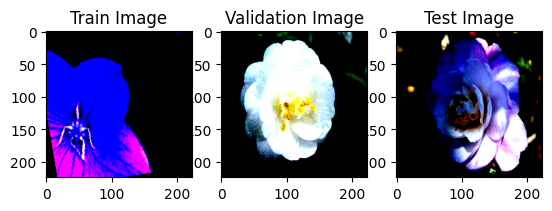

In [35]:
plt.figure()
f, axarr = plt.subplots(1, 3)
print(len(train_dataset))

# Transpose the image from (3, 224, 224) to (224, 224, 3)
img = train_dataset[0]["image"].squeeze().permute(1, 2, 0)
axarr[0].imshow(img)
axarr[0].set_title("Train Image")
print("-" * 30)


print(len(val_dataset))

# Transpose the image from (3, 224, 224) to (224, 224, 3)
img1 = val_dataset[10]["image"].squeeze().permute(1, 2, 0)
axarr[1].imshow(img1)
axarr[1].set_title("Validation Image")
print("-" * 30)


print(len(test_dataset))

# Transpose the image from (3, 224, 224) to (224, 224, 3)
img2 = test_dataset[6]["image"].squeeze().permute(1, 2, 0)
axarr[2].imshow(img2)
axarr[2].set_title("Test Image")
print("-" * 30)

In [ ]:
train_dataloader = DataLoader(
                        dataset=train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True
                    )

val_dataloader = DataLoader(
                        dataset=val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False
                    )

test_dataloader = DataLoader(
                        dataset=test_dataset,
                        batch_size=config.batch_size,
                        shuffle=False
                    )

In [37]:
train_dataloader.batch_size

16

In [38]:
classes = train_dataset.classes  
num_classes = len(classes)
classes, num_classes

(['balloon flower',
  'camellia',
  'clematis',
  'geranium',
  'japanese anemone',
  'magnolia',
  'purple coneflower',
  'spring crocus',
  'stemless gentian',
  'trumpet creeper'],
 10)

In [39]:
config = vit_config(num_classes = num_classes)
model = VisionTransformer(config)

### model structure

In [41]:
vit = VisionTransformer(config)
summary(model=vit, 
        input_size=(32, 3, 224, 224), 
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings= ["var_names"]
    )


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)         [32, 3, 224, 224]    [32, 10]             --                   True
├─VisionEmbedding (embedding)                 [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Sequential (patch_embedding)           [32, 3, 224, 224]    [32, 768, 196]       --                   True
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    │    └─Flatten (1)                       [32, 768, 14, 14]    [32, 768, 196]       --                   --
│    └─Dropout (dropout)                      [32, 197, 768]       [32, 197, 768]       --                   --
├─VisionEncoder (encoder)                     [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                    --                   --                  

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=config.adam_betas, lr = config.learning_rate, weight_decay=config.adam_weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs)

start = timeit.default_timer()

for epoch in range(config.epochs):
    
    # training
    model.train()
    
    train_labels = []
    train_preds = []
    train_running_loss = 0
    
    for idx, image in enumerate(tqdm(train_dataloader, position=0, desc="training")):
        img = image["image"].float().to(config.device)
        label = image["label"].type(torch.uint8).to(config.device)
        
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
    train_loss = train_running_loss/ (idx+1)
    
    #validation
    model.eval()
    valid_labels = []
    valid_preds = []
    valid_running_loss = 0
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_dataloader, position=0, desc="validation")):
            img = image["image"].float().to(config.device)
            label = image["label"].type(torch.uint8).to(config.device)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            valid_labels.extend(label.cpu().detach())
            valid_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            valid_running_loss += loss.item()
            
    val_loss = valid_running_loss/(idx + 1)
    
    print("-"*30)
    
    scheduler.step()
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    print("-"*30)
    print(f"Train loss epoch {epoch + 1}: {train_loss:.4f}")
    print(f"Valid loss epoch {epoch + 1}: {val_loss:.4f}") 
    print(f"Train accuracy epoch {epoch+1} : {sum(1 for x, y in zip(train_labels, train_preds) if x==y)/len(train_labels):.4f}")
    print(f"Valid accuracy epoch {epoch+1} : {sum(1 for x, y in zip(valid_labels, valid_preds) if x==y)/len(valid_labels):.4f}")
        
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s") 


In [43]:
test_images = []
test_preds = []
test_labels = []

model.eval()
with torch.no_grad():
    for idx, image in enumerate(tqdm(test_dataloader, position=0, desc="Testing")):
        img = image["image"].to(config.device)
        label = image["label"].to(config.device)
        
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        
        test_images.extend(img.cpu().detach())
        test_preds.extend([int(i) for i in y_pred_label])
        test_labels.extend(label.cpu().detach())

    print(f"Test accuracy : {sum(1 for x, y in zip(test_labels, test_preds) if x==y)/len(test_labels):.4f}")

Testing: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]

Test accuracy : 0.2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


<Figure size 800x500 with 0 Axes>

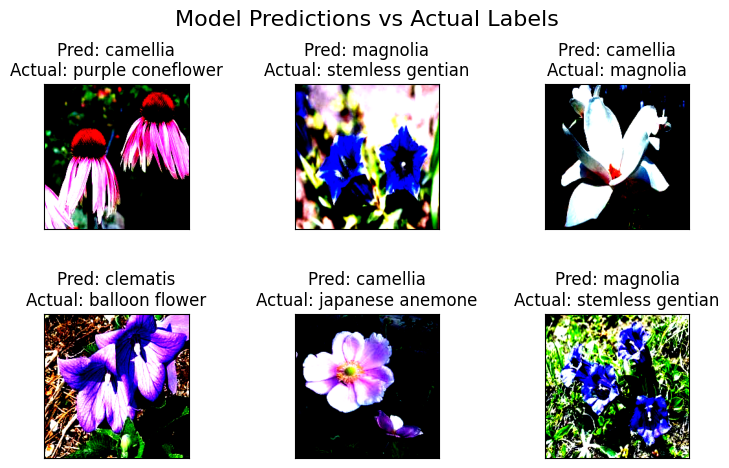

In [44]:
plt.figure(figsize=(8, 5))  # Larger figure for better visibility
f, axarr = plt.subplots(2, 3, figsize=( 8, 5))
counter = 0

for i in range(2):
    for j in range(3):
        # Display the image
        axarr[i][j].imshow(test_images[counter].squeeze().permute(1, 2, 0))
        
        # Get predicted and actual labels
        pred_label = classes[test_preds[counter]]
        actual_label = classes[test_labels[counter]]  # Assuming test_labels contains the true labels
        
        # Set title to show both predicted and actual labels
        axarr[i][j].set_title(f"Pred: {pred_label}\nActual: {actual_label}", fontsize=12)
        
        # Remove axis ticks for cleaner display
        axarr[i][j].set_xticks([])
        axarr[i][j].set_yticks([])
        
        counter += 1

plt.tight_layout(pad=3.0)  # Add padding between subplots
plt.suptitle("Model Predictions vs Actual Labels", fontsize=16, y=0.98)
plt.show()

### save model

In [23]:
# saving state dict
torch.save(model.state_dict(), 'vision_transformer_flowers.pth')

# saving full model
torch.save(model, 'vision_transformer_flowers_full.pth')

In [13]:
classes

['balloon flower',
 'camellia',
 'clematis',
 'geranium',
 'japanese anemone',
 'magnolia',
 'purple coneflower',
 'spring crocus',
 'stemless gentian',
 'trumpet creeper']

In [14]:
import os

# Adjust this to your actual flowers-data directory
base_dir = "flowers-data"

# The three sets we’re interested in
sets = ["train", "valid", "test"]

# The class folder names
classes = [
    "balloon flower",
    "camellia",
    "clematis",
    "geranium",
    "japanese anemone",
    "magnolia",
    "purple coneflower",
    "spring crocus",
    "stemless gentian",
    "trumpet creeper"
]

for dataset in sets:
    print(f"\n--- {dataset.upper()} ---")
    dataset_path = os.path.join(base_dir, dataset)
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        if os.path.exists(cls_path):
            # Count only files (filter out directories, if any)
            files = [
                f for f in os.listdir(cls_path)
                if os.path.isfile(os.path.join(cls_path, f))
            ]
            print(f"{cls}: {len(files)} images")
        else:
            print(f"{cls}: folder not found")



--- TRAIN ---
balloon flower: 16 images
camellia: 24 images
clematis: 19 images
geranium: 22 images
japanese anemone: 21 images
magnolia: 24 images
purple coneflower: 18 images
spring crocus: 23 images
stemless gentian: 21 images
trumpet creeper: 22 images

--- VALID ---
balloon flower: 9 images
camellia: 2 images
clematis: 7 images
geranium: 7 images
japanese anemone: 5 images
magnolia: 4 images
purple coneflower: 9 images
spring crocus: 6 images
stemless gentian: 6 images
trumpet creeper: 5 images

--- TEST ---
balloon flower: 5 images
camellia: 4 images
clematis: 4 images
geranium: 1 images
japanese anemone: 4 images
magnolia: 2 images
purple coneflower: 3 images
spring crocus: 1 images
stemless gentian: 3 images
trumpet creeper: 3 images
